# Part 1: Working out backward functions

**Question 1**: Let $f(X, Y) = X \oslash Y$ for two matrices $X$ and $Y$ (where the division is
element-wise). Derive the backward for $X$ and for $Y$. Show the derivation.

```Answer:```

Let $Z = f(X, Y)$. 

The backward for $X$ is: $ \frac{\partial Loss}{\partial X} = 
\frac{\partial L}{\partial Z} \odot \frac{\partial Z}{\partial X}$.

Then, we have:

$$
z_{i,j} = \frac{x_{i,j}}{y_{i,j}}
$$

$$
    \frac{\partial Loss}{\partial x_{i,j}} = \sum_{k,l} \frac{\partial Loss}{\partial z_{k,l}} \cdot \frac{\partial z_{k,l}}{\partial x_{i,j}}
$$

$$
    = \sum_{k,l} \frac{\partial Loss}{\partial z_{k,l}} \cdot \frac{\partial \left (\frac{x_{k,l}}{y_{k,l}}\right)}{\partial x_{i,j}}
$$

$$
    = \sum_{k,l} z'_{k,l} \cdot \frac{\partial \left (\frac{x_{k,l}}{y_{k,l}}\right)}{\partial x_{i,j}}
$$

$$
    = \sum_{k,l} z'_{k,l} \cdot \frac{1}{y_{i,j}} \cdot \delta_{i,k} \cdot \delta_{j,l}
$$

$$
    = z'_{i,j} \cdot \frac{1}{y_{i,j}}
$$
Therefore:

$$
    X'= Z' \odot (1 \oslash Y)
$$

Similarly, the backward for $Y$ is: $ \frac{\partial Loss}{\partial Y} = 
\frac{\partial L}{\partial Z} \odot \frac{\partial Z}{\partial Y}$.

$$
    \frac{\partial Loss}{\partial y_{i,j}} = \sum_{k,l} \frac{\partial Loss}{\partial z_{k,l}} \cdot \frac{\partial z_{k,l}}{\partial y_{i,j}}
$$

$$
    = \sum_{k,l} z'_{i,j} \cdot \frac{\partial \left (\frac{x_{k,l}}{y_{k,l}}\right)}{\partial y_{i,j}}
$$


$$
    = \sum_{k,l} z'_{k,l} \cdot - \frac{x_{k,l}}{y^2_{k,l}} \cdot \delta_{i,k} \cdot \delta_{j,l}
$$


$$
    = z'_{i,j} \cdot - \frac{x_{i,j}}{y^2_{i,j}}
$$

Therefore:
$$
    Y' = Z' \odot (- X \oslash Y^2)
$$


**Question 2**: Let $f$ be a scalar-to-scalar function $f: \mathbb{R} \rightarrow \mathbb{R}$. Let $F(X)$ be a tensor-to-tensor
function that applies $f$ element-wise (For a concrete example think of the sigmoid function
from the lectures). Show that whatever $f$ is, the backward of $F$ is the element-wise
application of $f'$ applied to the elements of $X$, multiplied (element-wise) by the gradient of the
loss with respect to the outputs.

```Answer:```

Let $Y = F(X)$, the gradient of the loss with respect to the output is: $\frac{\partial Loss}{\partial Y}$.

Then:
$$
x'_{i,j} = \frac{\partial Loss}{x_{i,j}}
$$

By the chain rule, we have:

$$
\frac{\partial Loss}{\partial x_{i,j}} = \frac{\partial Loss}{\partial y_{i,j}} \cdot \frac{\partial y_{i,j}}{\partial x_{i,j}}
$$

Since $y_{i,j} = f(x_{i,j})$, we have $\frac{\partial y_{i,j}}{\partial x_{i,j}} = f'(x_{i,j})$. Therefore, we can rewrite the equation as:

$$
x'_{i,j} = \frac{\partial Loss}{\partial y_{i,j}} \cdot f'(x_{i,j})
$$

$$
X' = \frac{\partial Loss}{Y} \odot f'(X)
$$


**Question 3**: Let matrix $W$ be the weights of an MLP layer with $f$ input nodes and $m$ output
nodes, with no bias and no nonlinearity, and let $X$ be an $n-by-f$ batch of $n$ inputs with $f$
features each. Which matrix operation computes the layer outputs? Work out the backward
for this operation, providing gradients for both $W$ and $X$

```Answer:```


Let $Y = X \cdot W^T$


Computing the gradient of the loss with respect to the weights we get: $$\frac{\partial Loss}{\partial w_{ij}} = \sum_{k=1}^{n} \frac{\partial Loss}{\partial y_{k,i}} \cdot x_{k,j}$$
Computing the gradient of the loss with respect to the inputs we get: $$\frac{\partial Loss}{\partial x_{i,j}} = \sum_{k=1}^{m} \frac{\partial Loss}{\partial y_{i,k}} \cdot W_{k,j}$$


The result of these operations are: $\frac{\partial Loss}{\partial W} = (\frac{\partial Loss}{\partial Y})^T \cdot X$,


and: $\frac{\partial Loss}{\partial X} = \frac{\partial Loss}{\partial Y} \cdot W^T$

**Question 4**: Let $f(x) = Y$ be a function that takes a vector $\vec{x}$, and returns the matrix $Y$
consisting of 16 columns that are all equal to $\vec{x}$. Work out the backward of $f$. (This may seem
like a contrived example, but it's actually an instance of broadcasting).

```Answer:```


The derivative of each element $y_{i,j}$ with respect to $x_k$ is given by the Kronecker delta: $$\frac{\partial y_{i,j}}{\partial x_k} = \delta_{i,k}$$

The gradient of the loss with respect to $x_k$ is the sum of the gradients of the loss with respect to the corresponding elements in each column of $Y$: 
$$\frac{\partial Loss}{\partial x_k} = \sum_{j=1}^{16} \frac{\partial Loss}{\partial y_{k,j}}$$

In matrix form, the gradient with respect to $x$ is the sum of the gradients with respect to each column of $Y$: $$\frac{\partial Loss}{\partial x} = \sum_{j=1}^{16} \frac{\partial Loss}{\partial y_{j}}$$

This means that each element of the gradient with respect to $\vec{x}$ is equal to the sum of the corresponding elements in the gradient with respect to $Y$. This is a result of the broadcasting operation in the backward pass.

# Part 2: Backpropagation

In [1]:
# importing code from https://github.com/dlvu/vugrad.git
import os
import sys

import numpy as np
import vugrad as vg

**Question 5**: Open an `ipython` session or a jupyter notebook in the same directory as the
`README.md` file, and import the library with `import vugrad as vg`. Also do `import
numpy as np`.

Recreate the computation graph `C<-A+B`: create two tensor nodes a and b containing numpy
arrays of the same size, and sum them (using the + operator) to create a TensorNode c.
Answer the following questions (in words, tell us what these class members mean, don't just
copy/paste their values).

1) What does `c.value` contain?
2) What does `c.source` refer to?
3) What does `c.source.inputs[0]`.value refer to?
4) What does `a.grad` refer to? What is its current value?
<!-- $$
\begin{itemize}
    \item[1] What does c.value contain?
    \item[2] What does c.source refer to?
    \item[3] What does c.source.inputs[0].value refer to?
    \item[4] What does a.grad refer to? What is its current value?
\end{itemize}
$$ -->


In [2]:
# graph node C<-A+B
A = vg.TensorNode(np.random.randn(2,2))  # create A tensor
B = vg.TensorNode(np.random.randn(2,2))  # create B tensor
C = A + B                                # create C tensor

print("A:\n", A)
print("B:\n", B)
print("C:\n", C)
print('-'*80)

# 1)
print("C.value:\n", C.value, "\n", 
"C.value contains the value of the tensor C")
# 2)
print("C.source:\n", C.source, "\n", 
"C.source refers to the operation that generates the tensor C")
# 3)
print("C.source.inputs[0].value == A.value:\n", 
C.source.inputs[0].value == A.value, "\n", 
"C.source.inputs[0].value refers to the value of the tensor A")
# 4)
print("A.grad:\n", A.grad, "\n", 
"A.grad refers to the gradient of the tensor A, which is currently 0")

A:
 TensorNode[size (2, 2), source None].
B:
 TensorNode[size (2, 2), source None].
C:
 TensorNode[size (2, 2), source <class 'vugrad.core.Add'>].
--------------------------------------------------------------------------------
C.value:
 [[ 0.01862607  1.30675705]
 [-1.03440556 -0.5177402 ]] 
 C.value contains the value of the tensor C
C.source:
 C.source refers to the operation that generates the tensor C
C.source.inputs[0].value == A.value:
 [[ True  True]
 [ True  True]] 
 C.source.inputs[0].value refers to the value of the tensor A
A.grad:
 [[0. 0.]
 [0. 0.]] 
 A.grad refers to the gradient of the tensor A, which is currently 0


**Question 6**: You will find the implementation of TensorNode and OpNode in the file
vugrad/core.py. Read the code and answer the following questions:
1) An OpNode is defined by its inputs, its outputs and the specific operation it represents (i.e.
summation, multiplication). What kind of object defines this operation?

2) In the computation graph of question 5, we ultimately added one numpy array to another
(albeit wrapped in a lot of other code). In which line of code is the actual addition performed?

3) When an OpNode is created, its inputs are immediately set, together with a reference to
the op that is being computed. The pointer to the output node(s) is left None at first. Why is
this? In which line is the OpNode connected to the output nodes?

`Answer:`
1) The object that defines the operations (i.e.
summation, multiplication) is the Op object or class.

2) The actual addition is performed on line 324:
```python
class Add(Op):
    """
    Op for element-wise matrix addition.
    """
    @staticmethod
    def forward(context, a, b):
        assert a.shape == b.shape, f'Arrays not the same sizes ({a.shape} {b.shape}).'
        return a + b
```
3) Opnode hasn't compute any value yet, and therefore it does not know in which tensor it has to stores the values.
The line is the following:
```python
outputs = [TensorNode(value=output, source=opnode) for output in outputs_raw]
opnode.outputs = outputs
```

**Question 7**: When we have a complete computation graph, resulting in a TensorNode called
loss, containing a single scalar value, we start backpropagation by calling
`loss.backward()`
Ultimately, this leads to the `backward()` functions of the relevant Ops being called, which do
the actual computation. In which line of the code does this happen?
NOTE: Don't just give the line numbers (there may be small changes to the code), but show
the line in context in your report

`answer`

It is called at the following snippet, at line 97:

```python

        # If we've been visited by all parents, move down the tree
        if self.visits == self.numparents or start:
            if self.source is not None:
                self.source.backward()
        else:
            assert self.visits < self.numparents, f'{self.numparents} {self.visits} {self.name}'
```


**Question 8**: core.py contains the three main Ops, with some more provided in ops.py.
Choose one of the ops Normalize, Expand, Select, Squeeze or Unsqueeze, and show that
the implementation is correct. That is, for the given forward, derive the backward by hand
(mathematically in LaTeX), and show that it matches what is implemented.

The chosen operation is Normalize:

The Normalize operation is mathematically defined as:

$$
y_{i,j} = \frac{x_{i,j}}{\sum_{k=1}^n x_{i,k}}
$$

where $x$ is the input matrix, $y$ is the output matrix, and $n$ is the number of columns.

The backward pass is as follows:

$$
\frac{\partial Loss}{\partial x_{i,j}} = \sum_{k=1}^m \frac{\partial Loss}{\partial y_{k,j}} \frac{\partial y_{k,j}}{\partial x_{i,j}}
$$

where $m$ is the number of rows. The second term can be further expanded as:

$$
\frac{\partial y_{k,j}}{\partial x_{i,j}} = \begin{cases}
\frac{1}{\sum_{k=1}^n x_{i,k}} - \frac{x_{i,j}}{(\sum_{k=1}^n x_{i,k})^2} & \text{if } i = k \\
- \frac{x_{k,j}}{(\sum_{k=1}^n x_{i,k})^2} & \text{if } i \neq k
\end{cases}
$$

Using these expressions, we put it all together as:

$$
\frac{\partial Loss}{\partial x_{i,j}} = \frac{\partial Loss}{\partial y_{i,j}} \frac{1}{\sum_{k=1}^n x_{i,k}} - \frac{1}{(\sum_{k=1}^n x_{i,k})^2} \sum_{k=1}^m \frac{\partial Loss}{\partial y_{k,j}} x_{k,j}
$$

This matches the implementation in the backward method, where `go` is the gradient of the loss with respect to the output `y`, `x` is the input matrix, and `sumd` is the sum of each row of `x`. The code returns the gradient of the loss with respect to the input `x` as:

```python
(go / sumd) - ((go * x)/(sumd * sumd)).sum(axis=1, keepdims=True)
```
**Question 9**: The current network uses a Sigmoid nonlinearity on the hidden layer. Create an
Op for a ReLU nonlinearity (details in the last part of the lecture). Retrain the network.
Compare the validation accuracy of the Sigmoid and the ReLU versions.

```answer```

My Relu implementation in ops.py
```python
class ReLU(Op):
    """
    Op for element-wise application of ReLU function
    """

    @staticmethod
    def forward(context, input):

        context['input'] = input

        return np.maximum(input, 0)

    @staticmethod
    def backward(context, goutput):
        input = context['input']

        return goutput * (input > 0)
```

and in functions.py
```python
def relu(x):
    """
    :param x:
    :return:
    """
    return ReLU.do_forward(x)
```


In [3]:
# Train MLP
# CODE FROM PROFESSORS
class MLP(vg.Module):
    """
    A simple MLP with one hidden layer, and a sigmoid non-linearity on the hidden layer and a softmax on the
    output.
    """

    def __init__(self, input_size, output_size, hidden_mult=4, if_relu=False):
        """
        :param input_size:
        :param output_size:
        :param hidden_mult: Multiplier that indicates how many times bigger the hidden layer is than the input layer.
        """

        super().__init__()

        hidden_size = hidden_mult * input_size
        # -- There is no common wisdom on how big the hidden size should be, apart from the idea
        #    that it should be strictly _bigger_ than the input if at all possible.

        self.layer1 = vg.Linear(input_size, hidden_size)
        self.layer2 = vg.Linear(hidden_size, output_size)
        # -- The linear layer (without activation) is implemented in vugrad. We simply instantiate these modules, and
        #    add them to our network.

        self.if_relu = if_relu

    def forward(self, input):

        assert len(input.size()) == 2

        # first layer
        hidden = self.layer1(input)

        # non-linearity (sigmoid or relu) added by me
        if self.if_relu:
            hidden = vg.relu(hidden)
        else:
            hidden = vg.sigmoid(hidden)
        # -- We've called a utility function here, to mimin how this is usually done in pytorch. We could also do:
        #    hidden = Sigmoid.do_forward(hidden)

        # second layer
        output = self.layer2(hidden)

        # softmax activation
        output = vg.logsoftmax(output)
        # -- the logsoftmax computes the _logarithm_ of the probabilities produced by softmax. This makes the computation
        #    of the CE loss more stable when the probabilities get close to 0 (remember that the CE loss is the logarithm
        #    of these probabilities). It needs to be implemented in a specific way. See the source for details.

        return output

    def parameters(self):

        return self.layer1.parameters() + self.layer2.parameters()


In [9]:
# CODE FROM PROFESSORS
(xtrain, ytrain), (xval, yval), num_classes = vg.load_synth() # load synthetic data, going easy on my cpu
print(f'## loaded data:')
print(f'         number of instances: {xtrain.shape[0]} in training, {xval.shape[0]} in validation')
print(f' training class distribution: {np.bincount(ytrain)}')
print(f'     val. class distribution: {np.bincount(yval)}')
num_instances, num_features = xtrain.shape


n, m = xtrain.shape
b = 128
epochs = 20
lr = 0.01

results = {}

if_relus = [False, True]
for if_relu in if_relus:
    ## Instantiate the model
    mlp = MLP(input_size=num_features, 
              output_size=num_classes,
              hidden_mult=4,
              if_relu=if_relu)
    
    print(f'## Model with relu: {if_relu}')
    losses, accuracies = [], []
    print('\n## Starting training')
    for epoch in range(epochs):

        print(f'epoch {epoch:03}')

        ## Compute validation accuracy
        o = mlp(vg.TensorNode(xval))
        oval = o.value

        predictions = np.argmax(oval, axis=1)
        num_correct = (predictions == yval).sum()
        acc = num_correct / yval.shape[0]

        o.clear() # gc the computation graph
        print(f'       accuracy: {acc:.4}')
        accuracies.append(acc)

        cl = 0.0 # running sum of the training loss

        # We loop over the data in batches of size `b`
        for fr in range(0, n, b):

            # The end index of the batch
            to = min(fr + b, n)

            # Slice out the batch and its corresponding target values
            batch, targets = xtrain[fr:to, :], ytrain[fr:to]

            # Wrap the inputs in a Node
            batch = vg.TensorNode(value=batch)

            outputs = mlp(batch)
            loss = vg.logceloss(outputs, targets)
            # -- The computation graph is now complete. It consists of the MLP, together with the computation of
            #    the scalar loss.
            # -- The variable `loss` is the TensorNode at the very top of our computation graph. This means we can call
            #    it to perform operations on the computation graph, like clearing the gradients, starting the backpropgation
            #    and clearing the graph.
            # -- Note that we set the MLP up to produce log probabilties, so we should compute the CE loss for these.

            cl += loss.value
            # -- We must be careful here to extract the _raw_ value for the running loss. What would happen if we kept
            #    a running sum using the TensorNode?

            # Start the backpropagation
            loss.backward()

            # pply gradient descent
            for parm in mlp.parameters():
                parm.value -= lr * parm.grad
                # -- Note that we are directly manipulating the members of the parm TensorNode. This means that for this
                #    part, we are not building up a computation graph.

            # -- In Pytorch, the gradient descent is abstracted away into an Optimizer. This allows us to build slightly more
            #    complexoptimizers than plain graident descent.

            # Finally, we need to reset the gradients to zero ...
            loss.zero_grad()
            # ... and delete the parts of the computation graph we don't need to remember.
            loss.clear()

        print(f'   running loss: {cl/n:.4}')
        losses.append(cl/n)

        if if_relu == True: # store results
            results['relu'] = accuracies
            results['relu_loss'] = losses
        else:
            results['sigmoid'] = accuracies
            results['sigmoid_loss'] = losses

print(f'## Results:')
print(f'  sigmoid: {results["sigmoid"]} (loss: {results["sigmoid_loss"]})')
print(f'     relu: {results["relu"]} (loss: {results["relu_loss"]})')



## loaded data:
         number of instances: 60000 in training, 10000 in validation
 training class distribution: [32728 27272]
     val. class distribution: [5484 4516]
## Model with relu: False

## Starting training
epoch 000
       accuracy: 0.4459
   running loss: 0.524
epoch 001
       accuracy: 0.9449
   running loss: 0.107
epoch 002
       accuracy: 0.9814
   running loss: 0.06469
epoch 003
       accuracy: 0.987
   running loss: 0.05123
epoch 004
       accuracy: 0.9896
   running loss: 0.04456
epoch 005
       accuracy: 0.9906
   running loss: 0.04036
epoch 006
       accuracy: 0.9914
   running loss: 0.03736
epoch 007
       accuracy: 0.9918
   running loss: 0.03506
epoch 008
       accuracy: 0.9924
   running loss: 0.03324
epoch 009
       accuracy: 0.9926
   running loss: 0.03174
epoch 010
       accuracy: 0.9931
   running loss: 0.03046
epoch 011
       accuracy: 0.9931
   running loss: 0.02936
epoch 012
       accuracy: 0.9932
   running loss: 0.02839
epoch 013
       ac

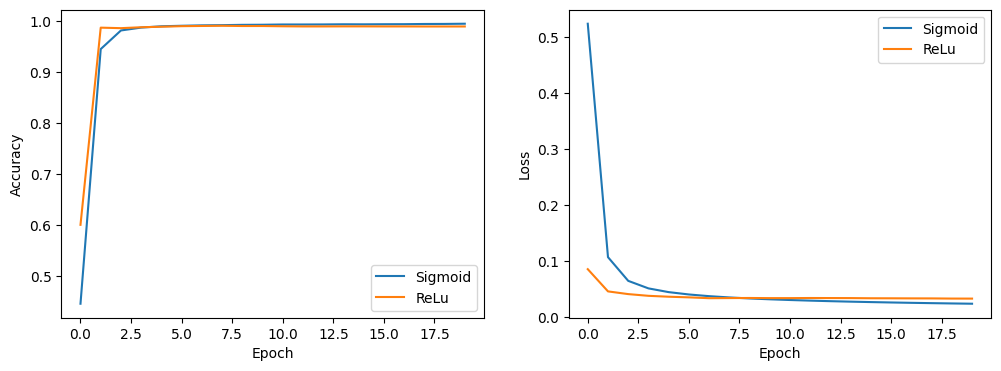

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline


fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(results['sigmoid'], label='Sigmoid')
axes[0].plot(results['relu'], label='ReLu')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')

axes[1].plot(results['sigmoid_loss'], label='Sigmoid')
axes[1].plot(results['relu_loss'], label='ReLu')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

axes[0].legend()
axes[1].legend()

plt.savefig('sigmoid_relu.pdf')
plt.show()

**Question 10**: Change the network architecture (and other aspects of the model) and show
how the training behavior changes for the MNIST data. Here are some ideas (but feel free to
try something else).

● Try adding more layers to the MLP, or widening the network (more nodes in the
hidden layer).

● Add a momentum term to the gradient descent. This is discussed in lecture 4.

● Try adding a residual connection between layers. These are also discussed in lecture 4.

● It is often said that good initialization is the key to neural network performance. What
happens if you replace the Glorot initialization (used in the Linear module) by
something else? If you initialize to all 0s or sample from a standard normal
distribution, do you see a drop in performance?

● If your computer is too slow to do this quickly enough on the MNIST data, you can
also work with the synthetic data, but it may be too simple to show the benefit of
things like residual connections. In that case, just report what you find.

# Part 3: Pytorch

**Question 11**:
Install pytorch using the installation instructions on its main page. Follow the Pytorch
60-minute blitz. When you've built a classifier, play around with the hyperparameters
(learning rate, batch size, nr of epochs, etc) and see what the best accuracies are that you
can achieve. Report your hyperparameters and your results.

In [22]:
!nvidia-smi && nvcc --version

Sun Nov 26 20:01:13 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8               2W / 105W |      0MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [16]:
import torch

device_name = torch.cuda.get_device_name()
print(device_name)

NVIDIA GeForce RTX 4070 Laptop GPU


**Question 12**:
Change some (at least one, if large enough of a change. To be safe try three), other aspects
of the training and report the results. For instance, the package torch.optim contains other
optimizers than SGD which you could try. There are also other loss functions. You could
even look into some tricks for improving the network architecture, like batch normalization or
residual connections. We haven't discussed these in the lectures yet, but there are plenty of
resources available online. Don't worry too much about getting a positive result, just report
what you tried and what you found.